# Internet Archive TV news analysis <a class="tocSkip">
This document contains the code and corresponding visualizations/statistics for answering various questions about the TV news dataset.

All times shown are H*:MM:SS.

In [1]:
%matplotlib inline
from query.datasets.prelude import *
import query.datasets.tvnews.queries as queries
import IPython

rudecarnie = Labeler.objects.get(name='rudecarnie')
mtcnn = Labeler.objects.get(name='mtcnn')

def format_time(seconds):
    return '{}:{:02d}:{:02d}'.format(seconds/3600, seconds/60 % 60, seconds % 60)

def show_df(table, ordering, clear=True):
    if clear:
        IPython.display.clear_output()
    return pd.DataFrame(table)[ordering]

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#All-videos" data-toc-modified-id="All-videos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>All videos</a></span></li><li><span><a href="#Videos-by-channel" data-toc-modified-id="Videos-by-channel-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Videos by channel</a></span></li><li><span><a href="#Videos-by-show" data-toc-modified-id="Videos-by-show-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Videos by show</a></span></li><li><span><a href="#Videos-by-time-of-day" data-toc-modified-id="Videos-by-time-of-day-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Videos by time of day</a></span></li></ul></li><li><span><a href="#Gender" data-toc-modified-id="Gender-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gender</a></span><ul class="toc-item"><li><span><a href="#Detector-accuracy" data-toc-modified-id="Detector-accuracy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Detector accuracy</a></span></li><li><span><a href="#Male-vs.-female-faces" data-toc-modified-id="Male-vs.-female-faces-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Male vs. female faces</a></span></li><li><span><a href="#Male-vs.-female-faces-across-channels" data-toc-modified-id="Male-vs.-female-faces-across-channels-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Male vs. female faces across channels</a></span></li><li><span><a href="#Male-vs.-female-faces-across-shows" data-toc-modified-id="Male-vs.-female-faces-across-shows-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Male vs. female faces across shows</a></span></li><li><span><a href="#Male-vs.-female-faces-across-time-of-day" data-toc-modified-id="Male-vs.-female-faces-across-time-of-day-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Male vs. female faces across time of day</a></span></li><li><span><a href="#Male-vs.-female-faces-across-topics" data-toc-modified-id="Male-vs.-female-faces-across-topics-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Male vs. female faces across topics</a></span></li><li><span><a href="#Male-vs.-female-faces-in-panels" data-toc-modified-id="Male-vs.-female-faces-in-panels-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Male vs. female faces in panels</a></span></li></ul></li><li><span><a href="#Pose" data-toc-modified-id="Pose-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pose</a></span></li><li><span><a href="#Misc" data-toc-modified-id="Misc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Misc</a></span><ul class="toc-item"><li><span><a href="#Number-of-people-in-frame" data-toc-modified-id="Number-of-people-in-frame-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Number of people in frame</a></span></li></ul></li></ul></div>

<hr />
# Dataset

In [20]:
def video_stats(vid_filter, label):
    vid_qs = vid_filter(Video.objects.all())
    count = vid_qs.count()
    times = np.array([video.num_frames / video.fps for video in vid_qs])
    return {
        'label': label,
        'count': count,
        'duration': format_time(int(np.sum(times))),
        'avg_duration': format_time(int(np.average(times)))
    }
ds_ordering = ['label', 'count', 'duration', 'avg_duration']

<hr />
## All videos

In [21]:
show_df([video_stats(lambda qs: qs, 'whole dataset')], ds_ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Videos by channel

In [22]:
show_df([
    video_stats(lambda qs: qs.filter(channel=channel), channel.name) 
    for channel in Channel.objects.all().order_by('id')], 
    ds_ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Videos by show
"Situation Room with Wolf Blitzer" and "Special Report with Bret Baier" were ingested as 60 10-minute segments each, whereas the other shows have 10 ≥1 hour segments.

In [23]:
show_df([
    video_stats(lambda qs: qs.filter(show=show), show.name) 
    for show in Show.objects.all().order_by('id')], 
    ds_ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Videos by time of day
Initial selection of videos was only prime-time, so between 4pm-11pm.

In [24]:
hours = [r['hour'] for r in 
         Video.objects.annotate(hour=Extract('time', 'hour')).distinct('hour').order_by('hour').values('hour')]

def format_hour(h):
    if h <= 12:
        return '{} AM'.format(h)
    else:
        return '{} PM'.format(h-12)
    
show_df([
    video_stats(lambda qs: qs.filter(time__hour=hour), format_hour(hour))
    for hour in hours], 
    ds_ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
# Gender
These queries analyze the distribution of men vs. women across a number of axes. We use faces detected by [MTCNN](https://github.com/kpzhang93/MTCNN_face_detection_alignment/) and gender detected by [rude-carnie](https://github.com/dpressel/rude-carnie). We only consider faces with a height > 20% of the frame to eliminate people in the background. Face detection was run at 2 frames per second on all videos. If a person's face is detected, we count that as 0.5 seconds of screen time. Total screen times reported double-count frames depending on the number of people in them, e.g. 2 women in one frame is 1 second of screen time.

Remaining questions:
* No. of unique women vs. unique men (identity-major)
* No. of frames w/ men vs. women (frame-major)

Add data:
* Sunday morning news
* General morning news shows (e.g. Today Show)


In [7]:
def calc_derived_gender_fields(row):
    total = float(row['male'] + row['female'])
    if total > 0:
        row['male_percent'] = '{:.0f}%'.format(row['male'] / total * 100)
        row['male_screentime'] = format_time(row['male'] / 2)
        row['female_percent'] = '{:.0f}%'.format(row['female'] / total * 100)
        row['female_screentime'] = format_time(row['female'] / 2)
    
def filter_gender(face_filter, video_filter):
    genders = list(Gender.objects \
        .annotate(count=Subquery(
            face_filter(FaceGender.objects \
            .filter(gender=OuterRef('pk'), labeler=rudecarnie, face__labeler=mtcnn) \
            .annotate(height=F('face__bbox_y2') - F('face__bbox_y1')) \
            .filter(height__gte=0.2)) \
            .values('gender').annotate(count=Count('*')) \
            .values('count'), models.IntegerField())).values())
    def zero_bad_val(n):
        if n is None or math.isnan(float(n)):
            return 0
        else:
            return n
    df = pd.DataFrame(genders)
    row = {
        'male': int(zero_bad_val(df.loc[df['name'] == 'male']['count'].values[0])),
        'female': int(zero_bad_val(df.loc[df['name'] == 'female']['count'].values[0] or 0)),
    }
    calc_derived_gender_fields(row)

    total_length = int(sum([v['length'] for v in video_filter(Video.objects) \
        .annotate(length=Sum(Cast(F('num_frames'), models.FloatField()) / F('fps'))) \
        .values('length')]))
    row['length'] = format_time(total_length)
    
    return row
   

ordering = ['length', 'male', 'male_percent', 'male_screentime', 'female', 'female_percent', 'female_screentime']

## Detector accuracy
* Handlabels are just for the "main person in the frame" (instruction to labelers), so precision is expected to be low.
* Recall for face and gender detectors is high.

In [33]:

# Frame.objects.annotate(c=Subquery(
#     Face.objects.filter(person__frame=OuterRef('pk'), labeler__name='handlabeled') \
#     .values('person__frame').annotate(c=Count('*')).values('c'), models.IntegerField())) \
#     .filter(c__gte=1) \
#     .count()

print(Frame.objects.count())
print(Frame.objects.filter(video__path__contains='segment').count())

20118856
2633003


In [8]:
# TODO: add data table for handlabeled subset
# TODO: deal with negative case
# TODO: how many errors on women vs. men?

face_labeler = Labeler.objects.get(name='mtcnn')
hand_labeler = Labeler.objects.get(name='handlabeled')
gender_labeler = Labeler.objects.get(name='rudecarnie')

face_tp = 0
face_fp = 0
face_fn = 0

gender_t = 0
gender_f = 0

handlabeled = [t['person__frame__video__id'] for t in Face.objects \
    .filter(labeler=hand_labeler) \
    .values('person__frame__video__id') \
    .distinct('person__frame__video__id') \
    .values('person__frame__video__id')]

for i, video in enumerate(Video.objects.filter(id__in=handlabeled)):
    frames_with_faces = Frame.objects \
        .filter(video=video) \
        .annotate(c=Subquery(
            Face.objects.filter(person__frame=OuterRef('pk')) \
            .values('person__frame') \
            .annotate(c=Count('*')).values('c'))) \
        .filter(c__gt=0)
    #print(i, video.path)
    for frame in frames_with_faces:
        handlabeled_faces = list(Face.objects.filter(person__frame=frame, labeler=hand_labeler))
        autolabeled_faces = list(Face.objects.filter(person__frame=frame, labeler=face_labeler))
        
        for autoface in autolabeled_faces:
            good = np.where(np.array([bbox_iou(autoface, handface) > 0.5 for handface in handlabeled_faces]))
            index = good[0][0] if len(good[0]) > 0 else None
            if index is not None:
                face_tp += 1
                auto_gender = FaceGender.objects.get(face=autoface)
                hand_gender = FaceGender.objects.get(face=handlabeled_faces[index])
                if auto_gender.gender == hand_gender.gender:
                    gender_t += 1
                else:
                    gender_f += 1
            else:
                face_fp += 1
            
        for handface in handlabeled_faces:
            good = any([bbox_iou(autoface, handface) > 0.5 for autoface in autolabeled_faces])
            if not good:
                face_fn += 1
    
print('Face precision: {:.2f}'.format(face_tp / float(face_tp + face_fp)))
print('Face recall: {:.2f}'.format(face_tp / float(face_tp + face_fn)))
print('Gender accuracy: {:.2f}'.format(gender_t / float(gender_t + gender_f)))

Face precision: 0.51
Face recall: 0.94
Gender accuracy: 0.94


<hr />
## Male vs. female faces
* Male:female ratio is 2:1

In [9]:
# TODO: have frame-major instead of face-major, e.g. split into male-only, female-only, mixed

show_df([filter_gender(lambda qs: qs, lambda qs: qs)], ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Male vs. female faces across channels
* No meaningful differnce in gender balance between CNN and FOX.

In [10]:
# compute t-test
counts = []
for channel in Channel.objects.all():
    c = filter_gender(
        lambda qs: qs.filter(face__person__frame__video__channel=channel), 
        lambda qs: qs.filter(channel=channel))
    c['channel'] = channel.name
    counts.append(c)
    
show_df(counts, ['channel'] + ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Male vs. female faces across shows
* Female-hosted shows (Poppy Harlow, Gretchen Carlson) have higher female percentages than any other show.
* Farreed Zakaria and Bret Baier are most male-imbalanced.

In [11]:
counts = []
for show in Show.objects.all():
    c = filter_gender(
        lambda qs: qs.filter(face__person__frame__video__show=show),
        lambda qs: qs.filter(show=show))
    c['show'] = show.name
    counts.append(c)
    
show_df(counts, ['show'] + ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Male vs. female faces across time of day
* No meaningful trend in gender balance across time of day.

In [12]:
hours = Video.objects.annotate(hour=Extract('time', 'hour')).distinct('hour').order_by('hour').values('hour')

counts = []
for hour in hours:
    hour = hour['hour']
    c = filter_gender(
        lambda qs: qs.filter(face__person__frame__video__time__hour=hour),
        lambda qs: qs.filter(time__hour=hour))
    c['hour'] = datetime.time(hour, 0).strftime('%I %p')
    counts.append(c)

show_df(counts, ['hour'] + ordering)    

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Male vs. female faces across topics
* Topic labeling is not robust enough to draw conclusions yet.

In [13]:
track_labeler = Labeler.objects.get(name='word2vec')
all_counts = []
for topic in Topic.objects.all():
    topic_counts = {'topic': topic.name, 'female': 0, 'male': 0, 'length': 0}
    for track in TopicTrack.objects.filter(topic=topic, labeler=track_labeler).select_related('video'):
        track_counts = filter_gender(
            lambda qs: qs.filter(
                face__person__frame__video=track.video, 
                face__person__frame__number__gte=track.min_frame, 
                face__person__frame__number__lte=track.max_frame),
            lambda qs: qs.filter(id=track.video.id)
        )
        topic_counts['male'] += track_counts['male']
        topic_counts['female'] += track_counts['female']
        topic_counts['length'] += int((track.max_frame - track.min_frame) / track.video.fps)
        
    calc_derived_gender_fields(topic_counts)
    topic_counts['length'] = format_time(topic_counts['length'])
    all_counts.append(topic_counts)
    
show_df(all_counts, ['topic'] + ordering)

QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
## Male vs. female faces in panels
* Smaller percentage of women in panels relative to overall dataset.

In [19]:
# TODO: female-domainated situations?
# TODO: slice this on # of people in the panel
# TODO: small visualization that shows sample of segments
# TODO: panels w/ majority male vs. majority female

print('Computing panels')
panels = queries.panels()
print('Computing gender stats')
frame_ids = [frame.id for (frame, _) in panels]
counts = filter_gender(lambda qs: qs.filter(face__person__frame__id__in=frame_ids), lambda qs: qs)
show_df([counts], ordering)

Computing panels
Computing gender stats


QgridWidget(grid_options={'enableTextSelectionOnCells': True, 'editable': True, 'explicitInitialization': True, 'minVisibleRows': 1, 'enableColumnReorder': False, 'defaultColumnWidth': 150, 'maxVisibleRows': 15, 'fullWidthRows': True, 'rowHeight': 28, 'autoEdit': False, 'syncColumnCellResize': True, 'forceFitColumns': True}, precision=5)

<hr />
# Pose
* Animatedness of people (specifically hosts)
    * e.g. Rachel Maddow vs. others
    * Pick 3-4 hours of a few specific hosts, compute dense poses and tracks
    * Devise acceleration metric
* More gesturing on heated exchanges?
* Sitting vs. standing
* Repeated gestures (debates vs. state of the union)
* Head/eye orientation (are people looking at each other?)
* Camera orientation (looking at someone from above/below)
* How much are the hosts facing each other
* Quantify aggressive body language

<hr />
# Misc

<hr />
## Number of people in frame
* Surprisingly, a plurality of frames have no detected faces in them.

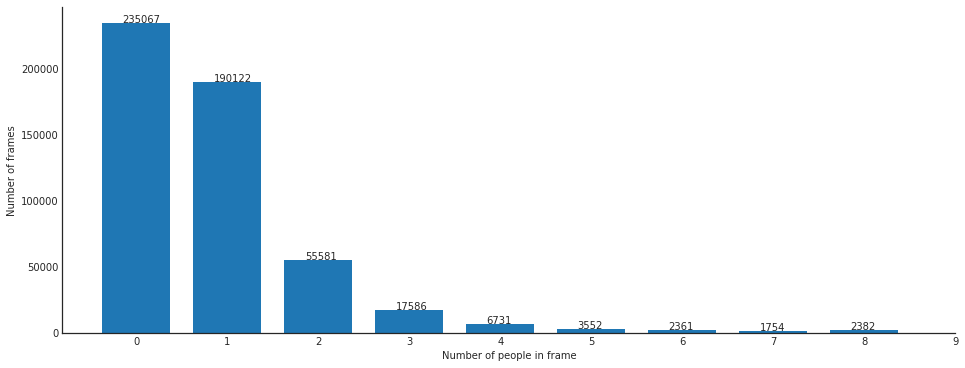

In [15]:
from django.db.models import Func
frames = Frame.objects.annotate(c=Subquery(
    Face.objects.filter(person__frame=OuterRef('pk'), labeler=mtcnn) \
    .values('person__frame') \
    .annotate(c=Count('*')) \
    .values('c'), models.IntegerField())) \
    .annotate(mod=F('number') % Cast(Func(F('video__fps'), function='ROUND'), models.IntegerField())) \
    .filter(mod=0) \
    .values('c')

all_counts = [f['c'] or 0 for f in frames]
ax = plt.figure(figsize=(16, 6)).add_subplot(111)
bins = range(10)
arr = ax.hist(all_counts, bins=bins, align='left', rwidth=0.75)
for i in bins:
    if i == 9: continue
    ax.text(arr[1][i]-0.15, arr[0][i], str(int(arr[0][i])))
ax.set_xticks(bins)
ax.set_xticklabels(bins)
ax.set_xlabel("Number of people in frame")
_ = ax.set_ylabel("Number of frames")